# Calibration analysis for multi-donor single-cell data

In [16]:
import pandas as pd
import numpy as np

import scanpy as sc
import scdali

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
N_PCS = 20

In [18]:
def qqplot(x, ax, **plot_kwargs):
    from scipy.stats import probplot
    (osm, osr), _ = probplot(x, dist='uniform')
    df = pd.DataFrame({'osm': -np.log10(osm), 'osr': -np.log10(osr)})
    sns.scatterplot(x='osm', y='osr', data=df, ax=ax, edgecolor=None, s=12, **plot_kwargs)
    m = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([0, m], [0, m], c='grey', linestyle=':')
    ax.set(xlabel=r'Expected $-\log_{10} P$', ylabel=r'Observed $-\log_{10} P$')
    
def get_cell_states(adata, N_PCS):
    E = adata.obsm['X_pca'][:, :N_PCS]
    return E / np.sqrt(np.var(E, 0))

In [19]:
np.random.seed(123)

## Load counts and PCs

In [5]:
adata = sc.read('../data/endoderm_ase_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 34254 × 3966
    obs: 'assigned', 'auxDir', 'cell_filter', 'cell_name', 'compatible_fragment_ratio', 'day', 'donor', 'expected_format', 'experiment', 'frag_dist_length', 'gc_bias_correct', 'is_cell_control', 'is_cell_control_bulk', 'is_cell_control_control', 'library_types', 'libType', 'log10_total_counts', 'log10_total_counts_endogenous', 'log10_total_counts_ERCC', 'log10_total_counts_feature_control', 'log10_total_counts_MT', 'log10_total_features', 'log10_total_features_endogenous', 'log10_total_features_ERCC', 'log10_total_features_feature_control', 'log10_total_features_MT', 'mapping_type', 'mates1', 'mates2', 'n_alt_reads', 'n_total_reads', 'num_assigned_fragments', 'num_bias_bins', 'num_bootstraps', 'num_compatible_fragments', 'num_consistent_mappings', 'num_inconsistent_mappings', 'num_libraries', 'num_mapped', 'num_processed', 'num_targets', 'nvars_used', 'pct_counts_endogenous', 'pct_counts_ERCC', 'pct_counts_feature_control', 'pct_counts_

In [6]:
adata = adata[adata.obs.sort_values('donor').index, :]
A = adata.X.A
D = adata.layers['allelic_total'].A
X = pd.get_dummies(adata.obs['donor']).to_numpy()

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## Randomize

### Permute cell states

In [7]:
E = get_cell_states(adata, N_PCS)
E = E[np.random.permutation(range(E.shape[0])), :]

In [8]:
adata.var[f'pval_pc{N_PCS}_dali_rnd'] = scdali.run_scdali(
    A=A, D=D, model='scDALI-Het', cell_state=E, n_cores=10)['pvalues']

[scdali] Processing 3966 regions on 10 core(s) ... 


100%|██████████| 10/10 [05:52<00:00, 35.23s/it]
Trying to set attribute `.var` of view, copying.


### Permute cell states within individuals

In [9]:
E_ids = adata.obs.groupby('donor').sample(frac=1).index
E = get_cell_states(adata[E_ids, :], N_PCS)

Not accounting for donor background

In [10]:
adata.var[f'pval_pc{N_PCS}_dali_rndrs'] = scdali.run_scdali(
    A=A, D=D, model='scDALI-Het', cell_state=E, n_cores=10)['pvalues']

[scdali] Processing 3966 regions on 10 core(s) ... 


100%|██████████| 10/10 [05:42<00:00, 34.20s/it]


Donor background as fixed effect

In [11]:
adata.var[f'pval_pc{N_PCS}_dalirs_rndrs'] = scdali.run_scdali(
    A=A, D=D, X=X, model='scDALI-Het', cell_state=E, n_cores=10)['pvalues']

[scdali] Processing 3966 regions on 10 core(s) ... 


100%|██████████| 10/10 [29:29<00:00, 176.96s/it] 


## Save

In [12]:
sc.write('../data/endoderm_ase_processed.h5ad', adata)

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


## Plot

In [20]:
plot_final = True

OUT_RC_PARAMS = {'font.size': 8, 'figure.figsize': (2.8, 2.3)} if plot_final else {}
for k, v in OUT_RC_PARAMS.items():
    plt.rcParams[k] = v

In [21]:
adata = sc.read('../data/endoderm_ase_processed.h5ad')

/icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/ipsc_endoderm/notebooks/utils.py:68: RuntimeWarning: divide by zero encountered in log10
  df = pd.DataFrame({'osm': -np.log10(osm), 'osr': -np.log10(osr)})


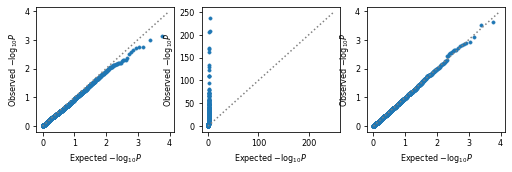

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(3 * plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][1]))
qqplot(adata.var[f'pval_pc{N_PCS}_dali_rnd'], axes[0])
qqplot(adata.var[f'pval_pc{N_PCS}_dali_rndrs'], axes[1])
qqplot(adata.var[f'pval_pc{N_PCS}_dalirs_rndrs'], axes[2])

/icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/ipsc_endoderm/notebooks/utils.py:68: RuntimeWarning: divide by zero encountered in log10
  df = pd.DataFrame({'osm': -np.log10(osm), 'osr': -np.log10(osr)})


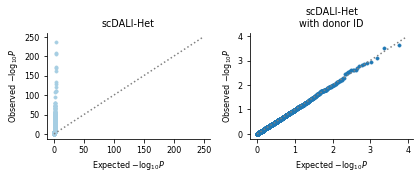

In [47]:
colors = np.asarray(np.asarray(sns.color_palette("Paired"))[:2])
fig, axes = plt.subplots(1, 2, figsize=(2.1 * plt.rcParams['figure.figsize'][0], 1.1*plt.rcParams['figure.figsize'][1]))
qqplot(adata.var[f'pval_pc{N_PCS}_dali_rndrs'], axes[0], rasterized=True, c=colors[np.newaxis, 0, :])
qqplot(adata.var[f'pval_pc{N_PCS}_dalirs_rndrs'], axes[1], rasterized=True, c=colors[np.newaxis, 1, :])
axes[0].set(title='scDALI-Het')
axes[1].set(title='scDALI-Het\nwith donor ID')
plt.tight_layout()
sns.despine()

if plot_final:
    plt.savefig('plots/calibration_qqplot.svg', dpi=300)